<a href="https://colab.research.google.com/github/ishandahal/ml_model_evaluation/blob/main/Cross_validation_Model_selection_Grid_search_Randomized_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install watermark

In [3]:
%load_ext watermark
%watermark -a 'ishan dahal' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

ishan dahal 
last updated: 2020-11-24 

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
mlxtend 0.14.0
matplotlib 3.2.2
sklearn 0.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt

### GridSearch
```GridSearchCV``` is useful for hyperparameter tuning

In [5]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split

X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=.15,
                                                    shuffle=True, stratify=y)

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=None)
gs.fit(X_train, y_train)

print(f"Brest Accuracy: {gs.best_score_*100:.2f}%")
print(f"Best Params: {gs.best_params_}")

Brest Accuracy: 96.09%
Best Params: {'criterion': 'gini', 'max_depth': 3}


In [7]:
for i in range(len(gs.cv_results_['mean_test_score'])):
    print(gs.cv_results_['mean_test_score'][i], gs.cv_results_['params'][i])

0.653846153846154 {'criterion': 'gini', 'max_depth': 1}
0.9121794871794873 {'criterion': 'gini', 'max_depth': 2}
0.9608974358974359 {'criterion': 'gini', 'max_depth': 3}
0.951923076923077 {'criterion': 'gini', 'max_depth': 4}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 5}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 6}
0.9602564102564102 {'criterion': 'gini', 'max_depth': None}
0.653846153846154 {'criterion': 'entropy', 'max_depth': 1}
0.9121794871794873 {'criterion': 'entropy', 'max_depth': 2}
0.9608974358974359 {'criterion': 'entropy', 'max_depth': 3}
0.9365384615384617 {'criterion': 'entropy', 'max_depth': 4}
0.9448717948717948 {'criterion': 'entropy', 'max_depth': 5}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': 6}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': None}


- GridSearchCV automatically refits the best model with the entire training set. 
- Looking at the heatmap of the results. Note, this only works on 1 or two hyperparameters

In [ ]:
from mlxtend.plotting import heatmap
import numpy as np
import pandas as pd

grid = np.zeros((2, 7))
grid[0, :] = gs.cv_results_['mean_test_score'][:7]
grid[1, :] = gs.cv_results_["mean_test_score"][7:]

heatmap(grid,
        column_names=[1, 2, 3, 4, 5, 6, 'None'],
        row_names=['gini', 'entropy'])
plt.ylabel('Criterion')
plt.xlabel('Max depth')
plt.show()

In [9]:
print(f"Accuracy: {gs.best_estimator_.score(X_test, y_test)*100:.2f}%")

Accuracy: 95.65%


- ```GridSearchCV``` is also compatible with the .632-Bootstrap iterator

In [10]:
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import BootstrapOutOfBag

param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,
                  cv=BootstrapOutOfBag(n_splits=200, random_seed=123),
                  n_jobs=None)
gs.fit(X_train, y_train)

print(f"Brest Accuracy: {gs.best_score_*100:.2f}%")
print(f"Best Params: {gs.best_params_}")
print(f"Accuracy: {gs.best_estimator_.score(X_test, y_test)*100:.2f}")

Brest Accuracy: 95.12%
Best Params: {'criterion': 'entropy', 'max_depth': 3}
Accuracy: 95.65


In [11]:
best_model_idx = np.argmin(gs.cv_results_['rank_test_score'])
scores = [gs.cv_results_[f'split{i}_test_score'][best_model_idx] for i in range(200)]

bootstrap_percentile_lower = np.percentile(scores, 2.5)
bootstrap_percentile_upper = np.percentile(scores, 97.5)
print(f"95% CI: [{100*round(bootstrap_percentile_lower, 4)},"
        f"{100*round(bootstrap_percentile_upper, 4)}]")

95% CI: [89.12,100.0]


- Note feature scaling does not matter in decisions trees but it does matter in other learning algorithms like K-Nearest Neighbors.
- To avoid introducing bias, we have to compute the parameters for scaling (e.g., the mean and std in context of z-score normalization) on the training fold to scale the training and test fold in a given iteration. 
- To make this more convenient, this is where scikit_learn's ```Pipeline``` class (or ```make_pipeline``` function) comes in handy as the next cell demonstrates

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipe = make_pipeline(StandardScaler(),
                     KNeighborsClassifier())

param_grid = [{'kneighborsclassifier__n_neighbors': list(range(1, 16)),
               'kneighborsclassifier__p': [1, 2]}]

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=-1,
                  cv=BootstrapOutOfBag(n_splits=200, random_seed=123))
gs.fit(X_train, y_train)

print(f"Best Accuracy: {gs.best_score_*100:.2f}%")
print(f"Best Params: {gs.best_params_}")
print(f"Accuracy: {gs.best_estimator_.score(X_test, y_test)*100:.2f}%")

Best Accuracy: 94.78%
Best Params: {'kneighborsclassifier__n_neighbors': 12, 'kneighborsclassifier__p': 1}
Accuracy: 91.30%


### Randomized Search
- Each setting is sampled from a distribution (discrete or continuous) over possible parameter values
- Instead of running exhaustive combinations of all combinations of parameters like in ```GridSearch``` ```RandomizedSearchCV``` specifies a certain number of parameters to evaluate in ```n_iter```

### ParamSampler
- To explain these concepts, let's take a look at the ```ParaSampler``` forst, which is used under the hood of ```RandomizedSearchCV```

In [13]:
from sklearn.model_selection import ParameterSampler

d = {'parameter 1': [1, 2, 3],
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10,
                      random_state=123)

list(ps)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


[{'parameter 1': 1, 'parameter 2': 'a'},
 {'parameter 1': 1, 'parameter 2': 'b'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'b'}]

- We can define probability distributions using SciPy's selection of distributions 
- Consider a discrete random uniform distribution for parameter 1 (not that in this case, there is a sampling with replacement from the distribution)

In [14]:
import scipy.stats

d = {'parameter 1': scipy.stats.randint(low=1, high=4),
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10,
                      random_state=123)
list(ps)

[{'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'a'},
 {'parameter 1': 1, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'a'}]

- Example for sampling from a uniform continuous distribution

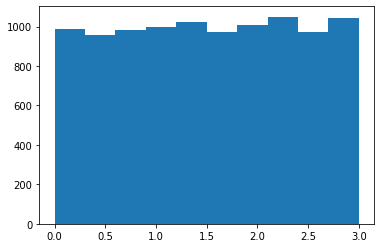

In [15]:
plt.hist(scipy.stats.uniform(loc=0, scale=3).rvs(10000))
plt.show()

In [16]:
d = {'parameter 1': scipy.stats.uniform(loc=1, scale=3),
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10,
                      random_state=123)
list(ps)

[{'parameter 1': 3.089407556793585, 'parameter 2': 'a'},
 {'parameter 1': 2.285412778560477, 'parameter 2': 'a'},
 {'parameter 1': 2.6539443072486737, 'parameter 2': 'b'},
 {'parameter 1': 2.473356800297792, 'parameter 2': 'b'},
 {'parameter 1': 3.9422925951538463, 'parameter 2': 'a'},
 {'parameter 1': 2.7390828910678304, 'parameter 2': 'b'},
 {'parameter 1': 2.1763525545824516, 'parameter 2': 'a'},
 {'parameter 1': 2.88195102801285, 'parameter 2': 'b'},
 {'parameter 1': 2.3157167340388733, 'parameter 2': 'b'},
 {'parameter 1': 3.084265531555807, 'parameter 2': 'a'}]

### RandomizedSearchCV example

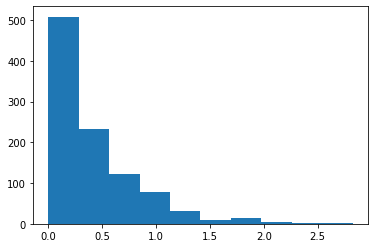

In [25]:
plt.hist(scipy.stats.expon(scale=0.4).rvs(1000))
plt.show()

In [18]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [19]:
gbm = HistGradientBoostingClassifier(random_state=123)

d = {'learning_rate': scipy.stats.expon(scale=0.4),
     'max_depth': scipy.stats.randint(low=3, high=10),
     'l2_regularization': scipy.stats.uniform(loc=0, scale=1)}

rcv = RandomizedSearchCV(estimator=gbm,
                         param_distributions=d,
                         n_iter=200,
                         cv=10,
                         refit=True,
                         random_state=123,
                         n_jobs=-1)
rcv.fit(X_train, y_train)

print(f"Best Accuracy: {rcv.best_score_*100:.2f}")
print(f"Best Params: {rcv.best_params_}")

Best Accuracy: 96.73
Best Params: {'l2_regularization': 0.7770044388897804, 'learning_rate': 0.011352363969357031, 'max_depth': 5}
